<b>Autor:</b> Joaquín Vázquez Palacios<br>
<b>Curso:</b> 4º INSO<br>
<b>Grupo:</b> B<br>
<b>Asignatura:</b> Aprendizaje Automático 2

# PRÁCTICA 1

In [1]:
library(caret)
library(caretEnsemble)
library(tidyverse)
library(Rcpp)
library(e1071)
library(ROCR)
library(kernlab)
library(xgboost)

urlPackage <- "https://cran.r-project.org/src/contrib/Archive/randomForest/randomForest_4.6-14.tar.gz"
install.packages(urlPackage, repos=NULL, type="source") 

Loading required package: ggplot2

Loading required package: lattice


Attaching package: 'caretEnsemble'


The following object is masked from 'package:ggplot2':

    autoplot


-- Attaching packages --------------------------------------- tidyverse 1.3.1 --

v tibble  3.1.0     v dplyr   1.0.5
v tidyr   1.1.4     v stringr 1.4.0
v readr   2.1.2     v forcats 0.5.1
v purrr   0.3.4     

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x caretEnsemble::autoplot() masks ggplot2::autoplot()
x dplyr::filter()           masks stats::filter()
x dplyr::lag()              masks stats::lag()
x purrr::lift()             masks caret::lift()


Attaching package: 'kernlab'


The following object is masked from 'package:purrr':

    cross


The following object is masked from 'package:ggplot2':

    alpha



Attaching package: 'xgboost'


The following object is masked from 'package:dplyr':

    slice




In [2]:
load(file = "datosfideliza.rda")

In [5]:
str(datosfideliza)

'data.frame':	7411 obs. of  60 variables:
 $ CDTITULA: num  28 32 126 132 174 214 218 225 269 282 ...
 $ SOLOPEQ : num  0 0 0 0 0 0 0 0 0 0 ...
 $ TCULTIMO: num  1.32e+10 1.32e+10 1.32e+10 1.32e+10 1.32e+10 ...
 $ MESULTI : num  2 2 2 2 2 2 2 2 2 2 ...
 $ NOMESINA: num  12 12 12 12 12 12 12 12 12 12 ...
 $ HMLNUM  : num  2 3 3 1 1 1 2 2 2 2 ...
 $ EDAD    : num  48 36 40 55 38 58 48 26 26 61 ...
 $ CODEDAD : num  5 4 4 5 4 5 5 3 3 5 ...
 $ SEXO    : num  1 2 1 2 2 2 2 0 1 0 ...
 $ MUNI    : num  43123 43148 28127 28080 11007 ...
 $ CDPROVIN: num  43 43 28 28 11 46 12 39 50 31 ...
 $ CODCCAA : num  9 9 13 13 1 10 10 6 2 15 ...
 $ SITU    : num  2 2 2 1 1 2 1 1 2 2 ...
 $ CDICE   : num  3 5 4 2 1 3 1 4 5 4 ...
 $ ONLINE  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ PTORED  : num  0 0 0 0 1375 ...
 $ P_RED_UL: num  0 0 0 0 0 0 0 0 0 0 ...
 $ RECLAMAC: num  0 0 0 0 0 0 0 0 0 0 ...
 $ TARJ_ADI: num  0 1 0 1 0 0 0 1 0 1 ...
 $ VISITAS : num  0 0 0 0 0 0 0 0 0 0 ...
 $ PUNTOSCB: num  0 0 0 0 0 0 0 0 0 0

A continuación, mostraré unas gráficas de densidad comparando algunas variables con nuestro target REDIME. Las variables que he decidido mostrar no han sido elegidas de forma arbitraria. Este apartado lo estoy realizando después de haber realizado la práctica por el siguiente motivo; necesito saber cómo funciona algo para saber interpretar las gráficas y lo que 'nos quieren decir', por lo que las variables representadas son las que, en algún punto de la práctica, un algoritmo nos dice que son las que mejor predicen en nuestro modelo y, por lo tanto, quería comprobarlo visualmente. Observamos que las densidades no se 'solapan' indicando así que, efectivamente, pueden ser buenas variables predictoras.

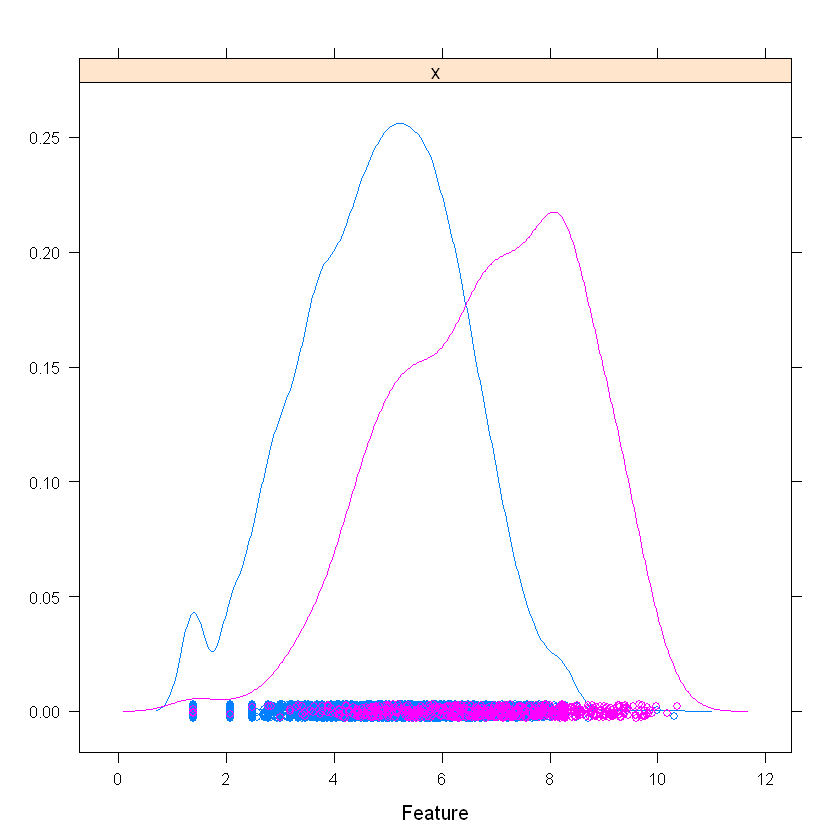

In [21]:
featurePlot(
  x = datosfideliza[,c("LNTOT3")],
  y = datosfideliza$REDIME,
  plot = "density"
)

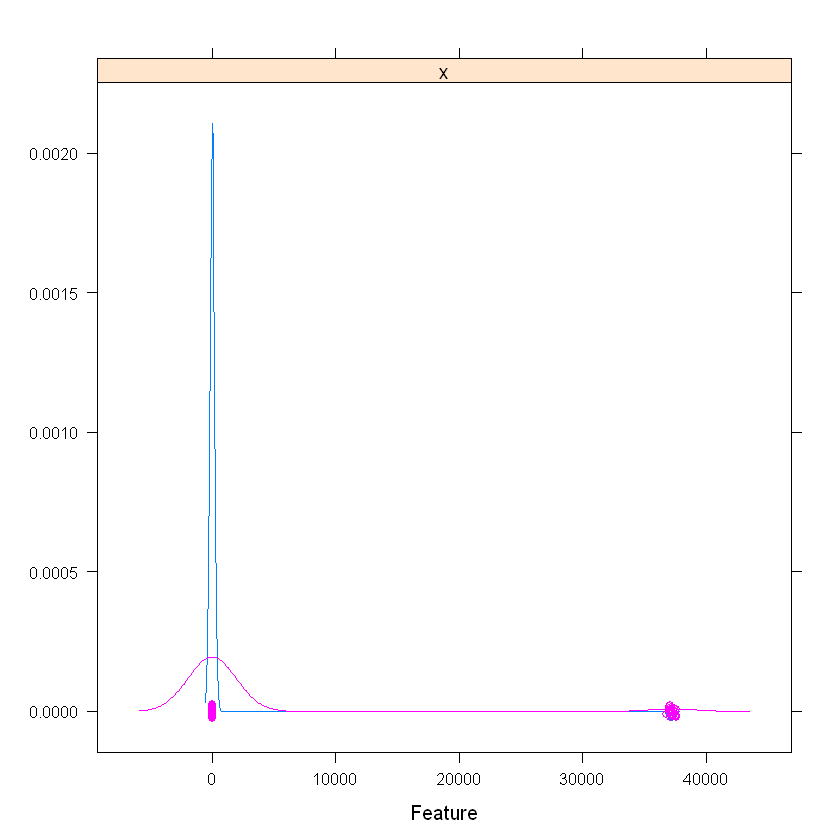

In [37]:
featurePlot(
  x = datosfideliza[,c("RECLAMAC")],
  y = datosfideliza$REDIME,
  plot = "density"
)

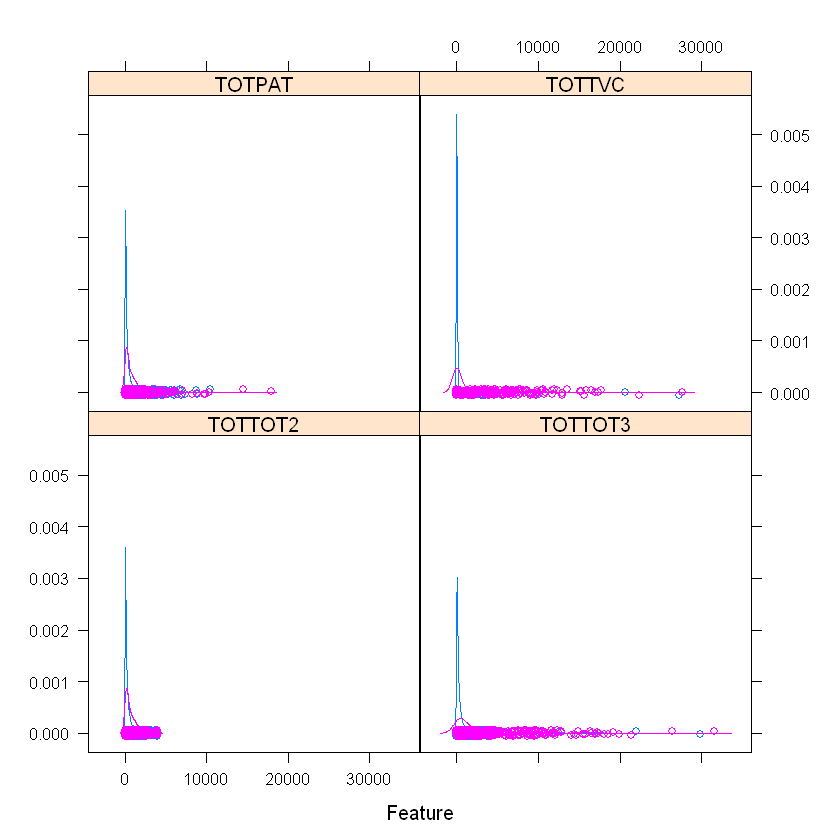

In [34]:
featurePlot(
  x = datosfideliza[,c("TOTTOT2", "TOTTOT3", "TOTPAT", "TOTTVC")],
  y = datosfideliza$REDIME,
  plot = "density"
)

Eliminamos de nuestro dataset las variables que consideramos que no aportan nada.

In [3]:
ignore <- c("CDTITULA", "SOLOPEQ", "TCULTIMO", "EDAD", "MUNI", "CDPROVIN", "SITU", "CDICE", "PTORED", "P_RED_UL", "PATBBV", "PATERK", "PATRPS", "PATTLF", "PATPEQ", "PATTOT", "PERFRED", "PERFR02", "PERFRHIS", "SEGPMP", "CRITERIO")
datosfideliza <- datosfideliza[,!(names(datosfideliza) %in% ignore)]

Pasamos REDIME a factor.

In [4]:
cols <- c("REDIME")
datosfideliza[cols] <- lapply(datosfideliza[cols], factor)

### Train y Test set.

Creamos nuestras particiones de train y test usando un 70/30 de los datos.

In [5]:
set.seed(355)
trainIndex <- createDataPartition(datosfideliza$REDIME, p = 0.7, list = FALSE)
trainingSet <- datosfideliza[trainIndex,]
testSet <- datosfideliza[-trainIndex,]

Guardamos la columna que contiene el target para deseleccionarla a lo largo del ejercicio.

In [6]:
targetColumn <- -c(26)

Preprocesamos los datos utilizando un modelo que nos 'imputa' los NAs.

In [7]:
set.seed(355)
bagMissing <- preProcess(trainingSet[targetColumn], method = "bagImpute")
trainingSet[targetColumn] <- predict(bagMissing, newdata = trainingSet[targetColumn])

Normalizamos las variables numéricas puesto que la mayoría de ellas son discretas.

In [8]:
rangeModel <- preProcess(trainingSet[targetColumn], method = "range")
trainingSet[targetColumn] <- predict(rangeModel, newdata = trainingSet[targetColumn])

Hacemos lo mismo con el testSet.

In [9]:
bagMissing <- preProcess(testSet[targetColumn], method = "bagImpute")
testSet[targetColumn] <- predict(bagMissing, newdata = testSet[targetColumn])
rangeModel <- preProcess(testSet[targetColumn], method = "range")
testSet[targetColumn] <- predict(rangeModel, newdata = testSet[targetColumn])

Nos curamos en salud poniendo los nombres de las columnas en la misma posición en ambos sets.

In [10]:
names(testSet) <- names(trainingSet)

Realizamos un perfil del algoritmo de Random Forest sobre nuestro dataset para que nos indique qué variables son las más relevantes y con cuantas de ellas será mejor el modelo.

In [23]:
rfeCtrl <- rfeControl(functions = rfFuncs,
                      method = "cv",
                      verbose = FALSE)

rfProfile <- rfe(x = trainingSet[targetColumn],
                 y = trainingSet$REDIME,
                 rfeControl = rfeCtrl)

rfProfile


Recursive feature selection

Outer resampling method: Cross-Validated (10 fold) 

Resampling performance over subset size:

 Variables Accuracy  Kappa AccuracySD KappaSD Selected
         4   0.9508 0.5219   0.007019  0.0889        *
         8   0.9508 0.5268   0.007598  0.0984         
        16   0.9505 0.5250   0.007801  0.1055         
        38   0.9507 0.5253   0.008015  0.1029         

The top 4 variables (out of 4):
   TOTTVC, RECLAMAC, TOTTOT3, LNTOT3


El resultado que nos ha escogido es el de 4 variables (TOTTVC, RECLAMAC, TOTTOT3, LNTOT3) dando un resultado de 0.95 de accuracy y un Kappa de 0.52. Hay que utilizar estos datos de manera puramente informativa. Siempre está bien hacer validaciones utilizando diferentes algoritmos para analizar nuestro dataset.

### Entrenamos el modelo.

Entrenamos utilizando el algoritmo de Random Forest con los valores por defecto.

In [24]:
rf <- train(REDIME ~ ., data = trainingSet, method = "rf")
rf

Random Forest 

5188 samples
  38 predictor
   2 classes: '0', '1' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 5188, 5188, 5188, 5188, 5188, 5188, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
   2    0.9494624  0.4935657
  20    0.9485819  0.5226889
  38    0.9471601  0.5197828

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 2.

Utilizamos una función que nos muestre la importacia de nuestras variables en la fase de entrenamiento con Random Forest.

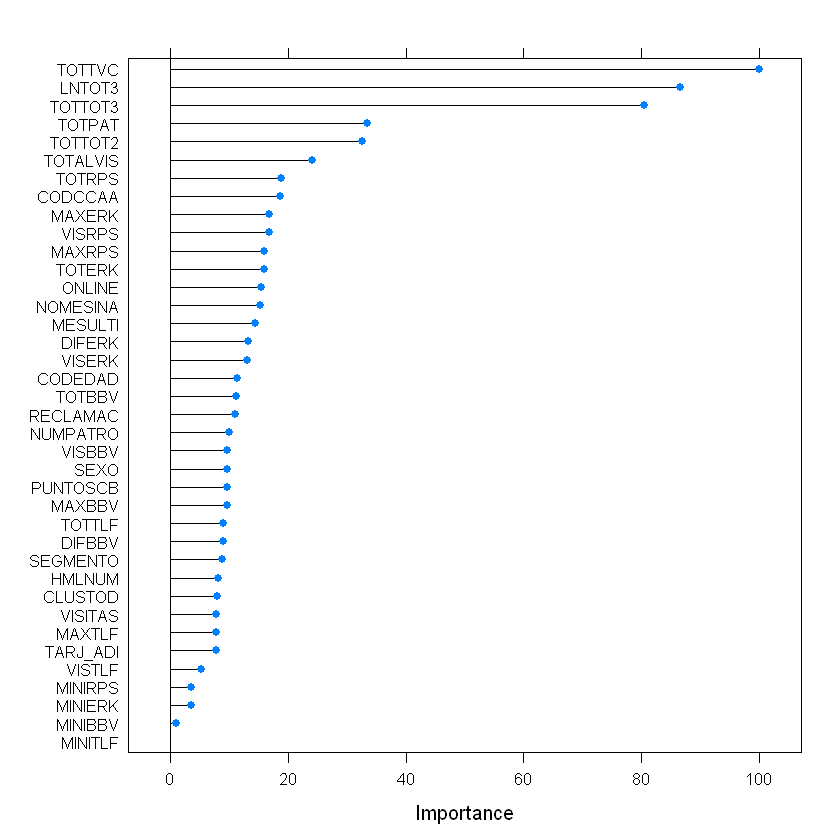

In [25]:
varimp_RF <- varImp(rf)
plot(varimp_RF)

Podemos observar que las variables más importantes coinciden 3 de 4 con el perfil que habíamos realizado previamente, exceptuando RECLAMAC.

### Matriz de confusión.

Analizando la matriz de confusión observamos un 0.95 de accuracy y un Kappa de 0.5, un modelo mediocre. Si nos fijamos en los valores de Sensitivity y Specificity nos damos cuenta de que nuestro modelo acierta en un 99% de las veces al clasificar correctamente la clase 0 pero tan solo un 36% al clasificar nuestra clase 1. Esto, muy probablemente se deba, entre otras cosas, al desbalanceo de nuestro target.

In [26]:
fitted <- predict(rf, testSet)
confusionMatrix(reference = testSet$REDIME, data = fitted, mode = "everything", positive = "1")

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 2050  107
         1    5   61
                                          
               Accuracy : 0.9496          
                 95% CI : (0.9397, 0.9583)
    No Information Rate : 0.9244          
    P-Value [Acc > NIR] : 1.265e-06       
                                          
                  Kappa : 0.5001          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.36310         
            Specificity : 0.99757         
         Pos Pred Value : 0.92424         
         Neg Pred Value : 0.95039         
              Precision : 0.92424         
                 Recall : 0.36310         
                     F1 : 0.52137         
             Prevalence : 0.07557         
         Detection Rate : 0.02744         
   Detection Prevalence : 0.02969         
      Balanced Accuracy 

### Mejorar el modelo.

Vamos a intentar mejorar el modelo realizando un 'hyperparameter tunning' al proceso de entrenamiento en vez de dejar los valores por defecto de Random Forest.

In [14]:
twoClassCtrl <- trainControl(
  method = "repeatedcv", # Repeated cross validation como método de control
  number = 5,
  repeats = 5,
  savePredictions = "final",
  classProbs = T,
  summaryFunction = twoClassSummary # Aquí le decimos que queremos un balance entre Specificity y Sensitivity 
)

Cambiamos los valores de nuestra variable target porque daba error la función de abajo por un conflicto con los nombres, no pueden ser 0 y 1. Los he cambiado por otros para que pueda trabajar el modelo.

In [11]:
levels(trainingSet$REDIME) <- c("NO_REDIME", "REDIME")
levels(testSet$REDIME) <- c("NO_REDIME", "REDIME")

Volvemos a entrenar usando Random Forest pero utilizando el 'tunning' de hiperparámetros configurado anteriormente.

In [18]:
rfTL <- train(REDIME ~ ., data = trainingSet, method = "rf", metric = "ROC", trControl = twoClassCtrl, tuneLength = 10)
rfTL

Random Forest 

5188 samples
  38 predictor
   2 classes: 'NO_REDIME', 'REDIME' 

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 5 times) 
Summary of sample sizes: 4150, 4151, 4150, 4151, 4150, 4151, ... 
Resampling results across tuning parameters:

  mtry  ROC        Sens       Spec     
   2    0.8537849  0.9972888  0.3659981
   6    0.8418963  0.9956204  0.4001233
  10    0.8371617  0.9948279  0.4092892
  14    0.8352032  0.9944526  0.4138656
  18    0.8334607  0.9939103  0.4174359
  22    0.8336410  0.9936601  0.4159039
  26    0.8332255  0.9934098  0.4184615
  30    0.8313071  0.9933264  0.4205063
  34    0.8314159  0.9933264  0.4210321
  38    0.8306262  0.9931178  0.4250893

ROC was used to select the optimal model using the largest value.
The final value used for the model was mtry = 2.

### Visualización curva ROC.

In [43]:
rfTLProb <- predict(rfTL, testSet, type = "prob")
predictions <- rfTLProb$REDIME
labels <- testSet$REDIME
pred <- prediction(predictions, labels)
pred

A prediction instance
  with 2223 data points

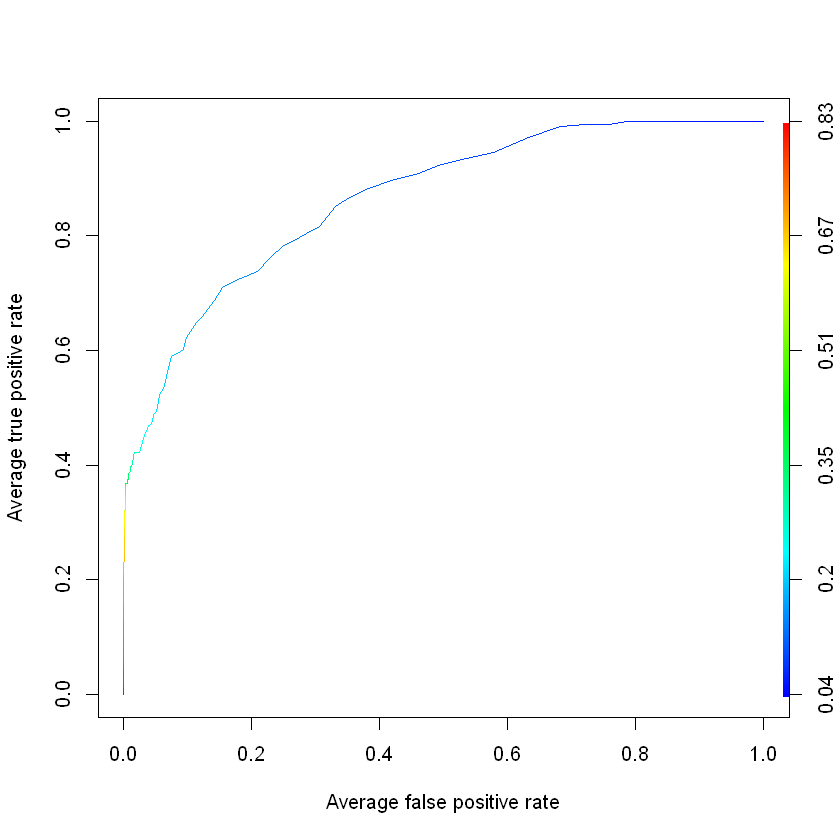

In [44]:
perf <- performance(pred, "tpr", "fpr")
plot(perf, avg = "threshold", colorize = TRUE)

Al final, el que mejor ROC tiene es el modelo con los valores por defecto puesto que la Specificity es la mima que el modelo anterior.
La matriz de confusión es idéntica.

In [23]:
fittedTL <- predict(rfTL, testSet)
confusionMatrix(reference = testSet$REDIME, data = fittedTL, mode = "everything", positive = "REDIME")

Confusion Matrix and Statistics

           Reference
Prediction  NO_REDIME REDIME
  NO_REDIME      2050    107
  REDIME            5     61
                                          
               Accuracy : 0.9496          
                 95% CI : (0.9397, 0.9583)
    No Information Rate : 0.9244          
    P-Value [Acc > NIR] : 1.265e-06       
                                          
                  Kappa : 0.5001          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.36310         
            Specificity : 0.99757         
         Pos Pred Value : 0.92424         
         Neg Pred Value : 0.95039         
              Precision : 0.92424         
                 Recall : 0.36310         
                     F1 : 0.52137         
             Prevalence : 0.07557         
         Detection Rate : 0.02744         
   Detection Prevalence : 0.02969         

Vamos a usar métodos de muestreo no estándar para ver cómo sale el modelo si hacemos upsampling del valor de REDIME menos representativo.

In [24]:
upCtrl <- trainControl(
  method = "boot", # Bootstrap como método de control
  number = 5,
  savePredictions = "final",
  classProbs = T,
  summaryFunction = twoClassSummary, # Aquí le decimos que queremos un balance entre Specificity y Sensitivity 
  sampling = "up"
)

In [27]:
rfUp <- train(REDIME ~ ., data = trainingSet, method = "rf", metric = "ROC", trControl = upCtrl, tuneLength = 10)
rfUp

Random Forest 

5188 samples
  38 predictor
   2 classes: 'NO_REDIME', 'REDIME' 

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 5 times) 
Summary of sample sizes: 4151, 4150, 4150, 4151, 4150, 4151, ... 
Addtional sampling using up-sampling

Resampling results across tuning parameters:

  mtry  ROC        Sens       Spec     
   2    0.8528352  0.9639625  0.4785329
   6    0.8381438  0.9879458  0.4072509
  10    0.8325333  0.9869030  0.4113470
  14    0.8313670  0.9853597  0.4143979
  18    0.8299780  0.9849009  0.4149107
  22    0.8270778  0.9834411  0.4164297
  26    0.8292536  0.9823983  0.4230380
  30    0.8271735  0.9816058  0.4189484
  34    0.8238762  0.9806882  0.4225252
  38    0.8229921  0.9791449  0.4194742

ROC was used to select the optimal model using the largest value.
The final value used for the model was mtry = 2.

In [41]:
upProb <- predict(rfUp, testSet, type = "prob")
predictions <- upProb$REDIME
labels <- testSet$REDIME
pred <- prediction(predictions, labels)
pred

A prediction instance
  with 2223 data points

Nos sale un valor de ROC ligeramente inferior al anterior. (NUEVO VALOR = 0.8528352, ANTERIOR VALOR = 0.8537849). <br>
Visualmente, las curvas ROC de ambos modelos son idénticas.

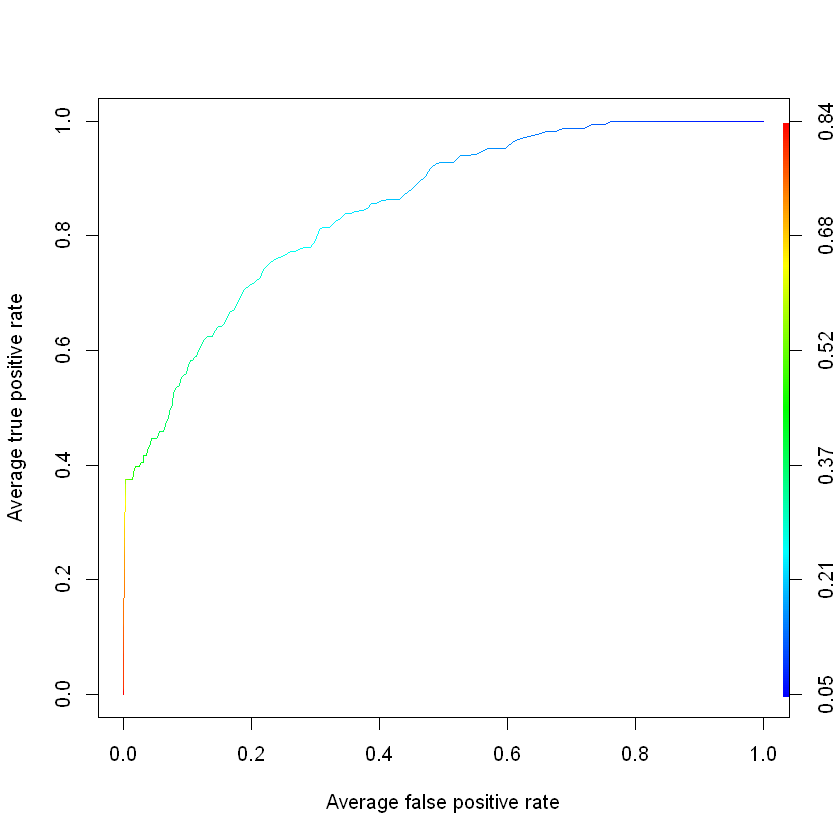

In [42]:
perf <- performance(pred, "tpr", "fpr")
plot(perf, avg = "threshold", colorize = TRUE)

### Comparación del rendimiento entre varios modelos.

Vamos a comparar de manera simultánea el rendimiento de los 4 algoritmos vistos en clase ensamblando los modelos utilizando caretList y realizando un upsampling como hemos hecho anteriormente.

In [12]:
methodCtrl <- trainControl(
  method = "repeatedcv",
  number = 5,
  repeats = 5,
  index = createFolds(trainingSet$REDIME, 5),
  savePredictions = "final",
  classProbs = T,
  sampling = "up",
  summaryFunction = twoClassSummary
)

In [ ]:
ensemble <- caretList(REDIME ~ ., trainingSet,
                      metric = "ROC",
                      trControl = methodCtrl,
                      tuneList = list(
                        rf = caretModelSpec(method = "rf", tuneLength = 10), 
                        glmnet = caretModelSpec(method = "glmnet", tuneLength = 10),
                        svm = caretModelSpec(method = "svmRadial", tuneLength = 5),
                        boosting = caretModelSpec(method = "xgbTree", tuneLength = 2) # Tuve que bajar este atributo a 2 porque 
                                                                                      # me quedaba sin memoria en mi máquina y se paraba el entrenamiento
                      )
)

Comparemos los 4 modelos con nuestro dataset. Vamos a tomar como referencia la información que se muestra abajo. El algoritmo que mejor rendimiento produce es el de 'boosting'. Fijémonos en las columnas de 'Median' y 'Mean' que son las importantes. En ROC es la que mejor resultados tiene seguido por 'glmnet'. En 'Sens' y 'Spec' 'boosting' es el que consigue un mejor equilibrio entre las dos (por lo que su curva ROC es mejor, obviamente). 'glmnet' consigue un mejor rendimiento en 'Spec' que 'boosting' pero en 'Sens' observamos que no se comporta tan bien. <br>

In [14]:
resampledList <- resamples(ensemble)
summary(resampledList)


Call:
summary.resamples(object = resampledList)

Models: rf, glmnet, svm, boosting 
Number of resamples: 5 

ROC 
              Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
rf       0.8163207 0.8200824 0.8383625 0.8329916 0.8414333 0.8487593    0
glmnet   0.8401466 0.8411940 0.8429287 0.8479670 0.8510744 0.8644914    0
svm      0.7882738 0.8053743 0.8054120 0.8103322 0.8229142 0.8296867    0
boosting 0.8343148 0.8383131 0.8543811 0.8484615 0.8559487 0.8593500    0

Sens 
              Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
rf       0.9515120 0.9653285 0.9726277 0.9702294 0.9794056 0.9822732    0
glmnet   0.8047445 0.8156934 0.8188217 0.8260167 0.8227320 0.8680918    0
svm      0.8527112 0.8597497 0.8615746 0.8644421 0.8636601 0.8845151    0
boosting 0.8391554 0.8561001 0.8579249 0.8746090 0.8886861 0.9311783    0

Spec 
              Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
rf       0.3821656 0.4095238 0.4190476 0.4147589 0.426751

### Conclusiones.

Todos los modelos rinden de forma parecida, pero el de 'boosting' destaca entre todos. Los algoritmos que nos realizan un perfil de nuestro dataset pueden ser una muy buena herramienta para 'guiarnos' sobre qué variables debemos poner el foco. Todas estas herramientas no dejan de ser algoritmos automatizados y, por lo tanto, debemos de utilizar esta información de forma estrictamente informativa. <br>
He decidido no utilizar Rattle puesto que me encuentro más cómodo trabajando directamente sobre código y, de alguna manera, 'veo' lo que está ocurriendo. Esto no quiere decir que Rattle no sea una herramienta estupenda, pero pienso que para formarme es mejor bajar al 'fango' y 'pegarme' con el código.